## **LSTM Based RUL Prediction**

In [1]:
# python libraries and packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
import plotly.graph_objects as go
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1, l2
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Training Data

In [ ]:
def estimate_rul(cycle_data):
  '''
  The function takes cycles data as input and return the RUL which is the difference between the maximum cyle and current cycle.
  '''
  cycle_data['RUL'] = max(cycle_data['Cycle']) - cycle_data['Cycle']
  return cycle_data

In [3]:
train_path = ["/content/drive/MyDrive/Project/Regression/Dataset/train_FD001.txt", "/content/drive/MyDrive/Project/Regression/Dataset/train_FD002.txt",
              "/content/drive/MyDrive/Project/Regression/Dataset/train_FD003.txt", "/content/drive/MyDrive/Project/Regression/Dataset/train_FD004.txt"]

test_path = ["/content/drive/MyDrive/Project/Regression/Dataset/test_FD001.txt", "/content/drive/MyDrive/Project/Regression/Dataset/test_FD002.txt",
              "/content/drive/MyDrive/Project/Regression/Dataset/test_FD003.txt", "/content/drive/MyDrive/Project/Regression/Dataset/test_FD004.txt"]

rul_path = ["/content/drive/MyDrive/Project/Regression/Dataset/RUL_FD001.txt", "/content/drive/MyDrive/Project/Regression/Dataset/RUL_FD002.txt",
              "/content/drive/MyDrive/Project/Regression/Dataset/RUL_FD003.txt", "/content/drive/MyDrive/Project/Regression/Dataset/RUL_FD004.txt"]

In [ ]:
# Code to find the correlation and drop highly correlated columns from the data

'''
# Calculate the correlation matrix
correlation_matrix = aerospace_data_train.corr()

# Set a threshold for correlation (e.g., 0.8), above which columns are considered highly correlated
correlation_threshold = 0.8

# Find columns with high correlation
highly_correlated_columns = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_columns.add(colname)

# Drop highly correlated columns from the DataFrame
# df = df.drop(columns=highly_correlated_columns)
print(highly_correlated_columns)
'''


# code to find the max length for padding sequences
'''
maxlen=0

for t in train_result:
  if maxlen<len(t):
    maxlen=len(t)
print(maxlen)
'''

'\nmaxlen=0\n\nfor t in train_result:\n  if maxlen<len(t):\n    maxlen=len(t)\nprint(maxlen)\n'

* Max length = 543

In [ ]:
# Calculating RUL from the sensors data
stacked_train_X=[]
stacked_train_y=[]
stacked_test_X=[]
stacked_test_y=[]

for i in range(4):

  print("Reading training file------> ", train_path[i].split('/')[-1])

  aerospace_data_train = pd.read_csv(train_path[i], sep=' ', header = None)
  aerospace_data_test = pd.read_csv(test_path[i], sep=' ', header = None)
  aerospace_RUL_test = pd.read_csv(rul_path[i], sep=' ', header = None)

  aerospace_RUL_test.reset_index(drop=True, inplace=True)
  print(aerospace_RUL_test.columns)
  aerospace_data_test.reset_index(drop=True, inplace=True)
  aerospace_data_train.reset_index(drop=True, inplace=True)



  # dropping null columns and renaming columns
  aerospace_data_train = aerospace_data_train.drop([26,27], axis='columns')
  aerospace_data_train.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

  # dropping null columns and renaming columns
  aerospace_data_test = aerospace_data_test.drop([26,27], axis='columns')
  aerospace_data_test.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

  # dropping null columns and renaming columns
  aerospace_RUL_test = aerospace_RUL_test.drop([1], axis='columns')
  aerospace_RUL_test.columns = ['RUL']

  #PARAMETERS--------------------
  window = 7

  #------------------------------

  #SCALING INITIALIZATION--------
  scaler = MinMaxScaler()

  #------------------------------


  #TRAINING DATA-----------------
  aerospace_data_train_RUL = aerospace_data_train.groupby('ID').apply(estimate_rul)

  columns_to_scale = ['OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1',
        'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
        'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
        'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
        'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
        'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
        'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21', 'RUL']

  aerospace_data_train_RUL[columns_to_scale] = scaler.fit_transform(aerospace_data_train_RUL[columns_to_scale])

  y_train = [aerospace_data_train_RUL[aerospace_data_train_RUL['ID']==id]['RUL'].max() for id in aerospace_data_train_RUL.ID.unique()]

  train_result = [aerospace_data_train_RUL[aerospace_data_train_RUL['ID']==mId][columns_to_scale[:-1]].values for mId in aerospace_data_train_RUL['ID'].unique()]

  #------------------------------


  #TESTING DATA------------------
  test_data_unique_ids = list(aerospace_data_test['ID'].unique())
  y_test = np.array(aerospace_RUL_test.RUL.to_list())



  rul = []
  for i in range(len(aerospace_data_test)):
    rul.append(y_test[aerospace_data_test['ID'][i]-1])

  aerospace_data_test['RUL'] = rul
  aerospace_data_test[columns_to_scale] = scaler.transform(aerospace_data_test[columns_to_scale])

  y_test = [aerospace_data_test[aerospace_data_test['ID']==id]['RUL'].max() for id in aerospace_data_test.ID.unique()]
  test_result = [aerospace_data_test[aerospace_data_test['ID']==mId][columns_to_scale[:-1]].values for mId in test_data_unique_ids]

  #------------------------------


  #PADDING CONVERSION --------------

  maxlen=543
  padded_sequence_train = pad_sequences(train_result, padding='post', maxlen=maxlen, dtype='float32')
  padded_sequence_test = pad_sequences(test_result, padding='post', maxlen=maxlen, dtype='float32')

  print('TRAIN: ', len(padded_sequence_train), len(y_train))
  print('TEST: ', len(padded_sequence_test), len(y_test))

  # ---------------------------------

  # here comes the shuffled data for training and testing with their outputs
  stacked_train_X.append(padded_sequence_train)
  stacked_train_y.append(y_train)
  stacked_test_X.append(padded_sequence_test)
  stacked_test_y.append(y_test)

Reading training file------>  train_FD001.txt
Int64Index([0, 1], dtype='int64')
TRAIN:  100 100
TEST:  100 100
Reading training file------>  train_FD002.txt
Int64Index([0, 1], dtype='int64')
TRAIN:  260 260
TEST:  259 259
Reading training file------>  train_FD003.txt
Int64Index([0, 1], dtype='int64')
TRAIN:  100 100
TEST:  100 100
Reading training file------>  train_FD004.txt
Int64Index([0, 1], dtype='int64')
TRAIN:  249 249
TEST:  248 248


In [ ]:
print("Before Padding")
train_result[0]

Before Padding


array([[0.9999262 , 0.9976247 , 1.        , ..., 1.        , 0.01547259,
        0.01588122],
       [0.4761474 , 0.83159145, 1.        , ..., 1.        , 0.47796838,
        0.48148689],
       [0.99990002, 0.99869359, 1.        , ..., 1.        , 0.01076354,
        0.01893163],
       ...,
       [0.23807132, 0.29928741, 1.        , ..., 1.        , 0.62933064,
        0.63638917],
       [0.47624262, 0.83159145, 1.        , ..., 1.        , 0.49579549,
        0.5020645 ],
       [0.99994763, 0.9976247 , 1.        , ..., 1.        , 0.02186344,
        0.0210495 ]])

In [ ]:
print("After Padding")
padded_sequence_train[0]

After Padding


array([[0.9999262 , 0.9976247 , 1.        , ..., 1.        , 0.01547259,
        0.01588122],
       [0.4761474 , 0.8315914 , 1.        , ..., 1.        , 0.4779684 ,
        0.4814869 ],
       [0.99990004, 0.9986936 , 1.        , ..., 1.        , 0.01076354,
        0.01893163],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
# This keeps (train_FD001, train_FD002, train_FD003, train_FD004) and concatenated to form a single bigger dataset with targets
processed_train_data = np.concatenate(stacked_train_X, axis=0)
processed_train_targets = np.concatenate(stacked_train_y, axis=0)

processed_test_data = np.concatenate(stacked_test_X, axis=0)
processed_test_targets = np.concatenate(stacked_test_y, axis=0)

print(f"Shape of processed_train_data: {processed_train_data.shape}")
print(f"Shape of processed_test_data: {processed_test_data.shape}")
print(f"Shape of processed_train_targets: {processed_train_targets.shape}")
print(f"Shape of processed_test_targets: {processed_test_targets.shape}")

Shape of processed_train_data: (709, 543, 24)
Shape of processed_test_data: (707, 543, 24)
Shape of processed_train_targets: (709,)
Shape of processed_test_targets: (707,)


**Input Data Shape:** (describes: samples, timestep, features)

**LSTM Layer's Expected Input Shape:** Batch size, time steps, and features

### LSTM

In [ ]:
# defining model
model = Sequential([
    LSTM(128, input_shape=(processed_train_data.shape[1], processed_train_data.shape[2]), activation = "tanh", return_sequences=True),
    LSTM(64, activation = "tanh", return_sequences=True),
    LSTM(32, activation = "tanh"),
    Dropout(0.3),
    Dense(96, activation="relu", kernel_regularizer=l1(0.01), activity_regularizer=l2(0.01)),  # Add L1 and L2 regularization
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dense(1, activation='linear')
])
model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.005))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 543, 128)          78336     
                                                                 
 lstm_1 (LSTM)               (None, 543, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 96)                3168      
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               1

In [ ]:
# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# training on defined epochs
history = model.fit(processed_train_data, processed_train_targets, epochs=100,
                    validation_split = 0.1,
                    batch_size=8, verbose=1, callbacks=[early_stopping])


Epoch 1/100
80/80 [==============================] - 26s 59ms/step - loss: 0.9907 - val_loss: 0.1013
Epoch 2/100
80/80 [==============================] - 4s 45ms/step - loss: 0.0543 - val_loss: 0.0429
Epoch 3/100
80/80 [==============================] - 5s 58ms/step - loss: 0.0404 - val_loss: 0.0456
Epoch 4/100
80/80 [==============================] - 4s 44ms/step - loss: 0.0396 - val_loss: 0.0351
Epoch 5/100
80/80 [==============================] - 4s 44ms/step - loss: 0.0415 - val_loss: 0.0373
Epoch 6/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0395 - val_loss: 0.0456
Epoch 7/100
80/80 [==============================] - 4s 51ms/step - loss: 0.0388 - val_loss: 0.0390
Epoch 8/100
80/80 [==============================] - 4s 46ms/step - loss: 0.0394 - val_loss: 0.0376
Epoch 9/100
80/80 [==============================] - 4s 45ms/step - loss: 0.0398 - val_loss: 0.0395


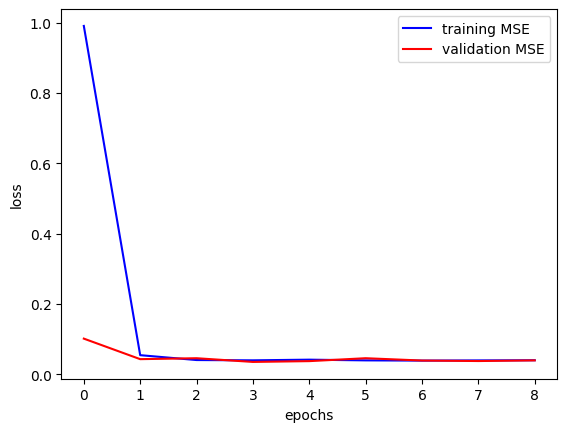

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training MSE', c= 'b')
plt.plot(history.history['val_loss'], label='validation MSE', c= 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
lstm_pred = model.predict(processed_test_data)

23/23 [==============================] - 1s 25ms/step


In [ ]:
print("Root Mean Squared Error (RMSE): ", np.sqrt(metrics.mean_squared_error(processed_test_targets, lstm_pred)))
print("Mean Absolute Error (MAE): ", metrics.mean_absolute_error(processed_test_targets, lstm_pred))
print("R2 Score: ", metrics.r2_score(processed_test_targets, lstm_pred))

Root Mean Squared Error (RMSE):  0.2901291569640561
Mean Absolute Error (MAE):  0.2654782250210549
R2 Score:  -4.746940397893326
